# Fourier Transform

Based on 3b1b video: https://www.youtube.com/watch?v=spUNpyF58BY

In [22]:
import time
import numpy as np
from statsmodels.tsa.tsatools import detrend
from scipy.signal import firwin, lfilter, welch
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt
import ipywidgets

## Create input signals

In [23]:
def create_signal(x, freq=1, amplitude=1):
    """
    Given a set of x values (or time values), return the corresponding y values
    in the form of a cosinus signal with the desired frequency and amplitude
    """
    y = amplitude * np.cos(x * freq * 2 * np.pi)

    return y


In [24]:
# define the time values in steps of 0.01
t = np.arange(5, step=0.01)
ampl = 2
# create two different signals
y = create_signal(t, freq=2, amplitude=ampl)
y_2 = create_signal(t, freq=0.3, amplitude=ampl)
# combine the two signals in 1
y_3 = y + y_2

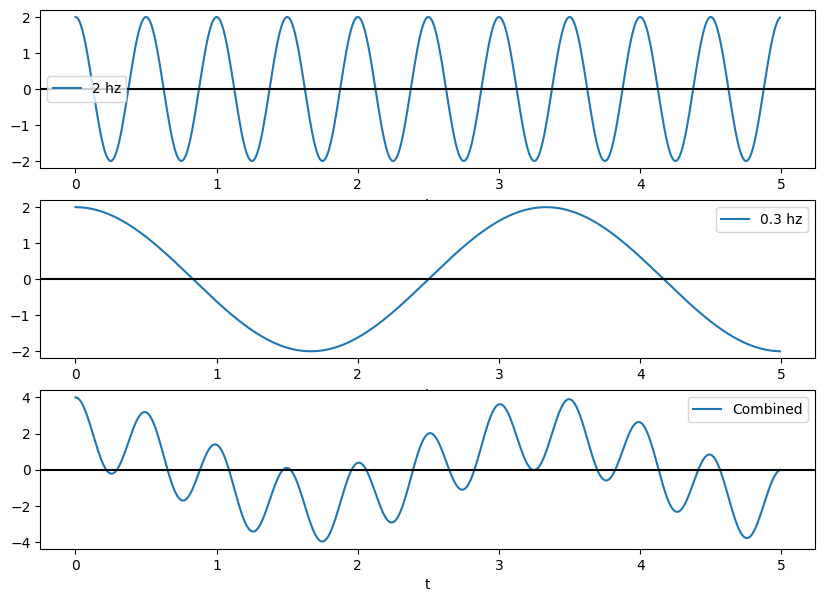

In [25]:
fig, axs = plt.subplots(3, 1, figsize=(10,7))

axs[0].plot(t, y, label="2 hz");
axs[1].plot(t, y_2, label="0.3 hz");
axs[2].plot(t, y_3, label="Combined");

for i in range(3):
    axs[i].legend();
    axs[i].set_xlabel('t');
    axs[i].axhline(y=0, color='k');

## Imaginary Plane (Euler)

In [26]:
def compute_euler(x):
    """
    Returns the resulting x and i (imaginary) values according to eulers formula on the given x values (angles)
    
    euler: e^x*i = cos(x) + i * sin(x) 
    same as horizontal value = cos(x) and vertical = sin(x)
    """
    euler_x = np.cos(x)
    euler_i = np.sin(x)

    return euler_x, euler_i

In [27]:
def plot_imaginary_plane(euler_x, euler_i):
    """
    Plots Euler's circular imaginary plane on the given euler values
    """
    plt.figure(figsize=(5, 5))

    plt.title("Imaginary Plane")
    plt.xlabel("X")
    plt.axhline(y=0, color='k');
    plt.axvline(x=0, color='k');
    plt.ylabel("i (imaginary)")
    plt.plot(euler_x, euler_i)

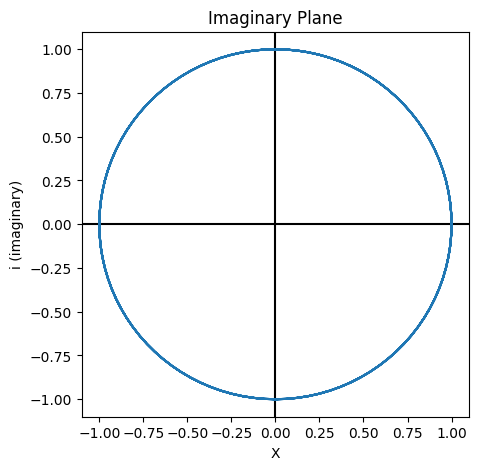

In [28]:
# euler_angles = np.arange(2*np.pi, step=0.01)
# we multiply the time values by 2*pi so that at time=1, we get a full circunference
# thus the resulting circular function makes 1 turn every 1 second
# we multiply by -1 so that the rotation is clockwise
euler_angles = -2 * np.pi * t
euler_x, euler_i = compute_euler(euler_angles)
plot_imaginary_plane(euler_x, euler_i)

## Fourier Transform (Discrete)

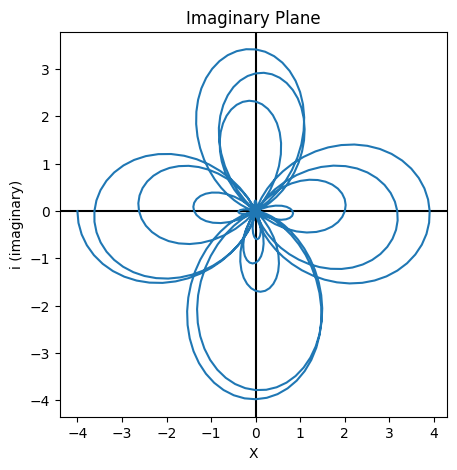

In [29]:
# if we multiply the euler values by the signal, we are wrapping that signal along the circular imaginary plane
# with a frequency of 1, meaning that at t = 1, the signal has completed a full turn on the plane
wrapped_x, wrapped_i = -y_3*euler_x, y_3*euler_i
plot_imaginary_plane(wrapped_x, wrapped_i)

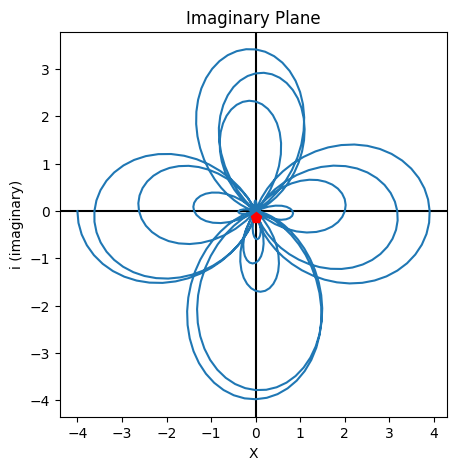

In [30]:
# The main idea of the fourier transform is that if we wrap that signal at the same frequency of the original signals that formed it, 
# the x coordinate of the "center of gravity" of the resulting graph should have a spike in its value
plot_imaginary_plane(wrapped_x, wrapped_i)
center_grav = (wrapped_x.mean(), wrapped_i.mean())
# plot the center of gravity onto the imaginary plane
plt.plot(*center_grav, 'rp', markersize=8);

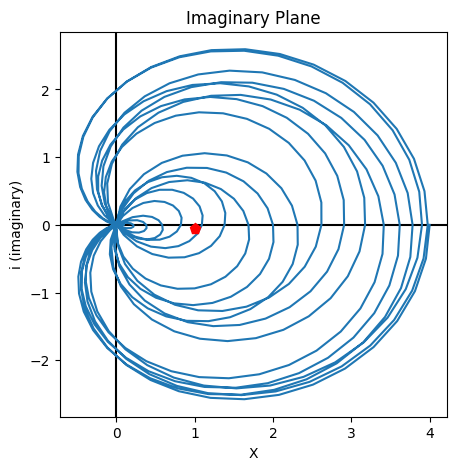

In [31]:
# we can change the circular wrapping frecuency by multiplying the euler angles by a given frequency
# thus resulting in euler(2*pi*freq*t) which is the formula of the fourier transform
freq = 2
# get the euler angles at the given frequence
euler_angles = -2 * np.pi * freq * t
# compute euler values
euler_x, euler_i = compute_euler(euler_angles)
# multiply by the signal to wrap it as a circle
wrapped_x, wrapped_i = y_3*euler_x, y_3*euler_i
# compute the center of gravity of the resulting funtion
center_grav = (wrapped_x.mean(), wrapped_i.mean())

plot_imaginary_plane(wrapped_x, wrapped_i)
# plot the center of gravity onto the imaginary plane
plt.plot(*center_grav, 'rp', markersize=8);

In [32]:
def get_wrapped_signal(t, signal, freq):
    """
    Returns the resulting wrapped signal as the x and i values at the desired frequency
    """
    # get the euler angles at the given frequence
    euler_angles = -2 * np.pi * freq * t
    # compute euler values
    euler_x, euler_i = compute_euler(euler_angles)
    # multiply by the signal to wrap it as a circle
    wrapped_x, wrapped_i = signal*euler_x, signal*euler_i

    return wrapped_x, wrapped_i

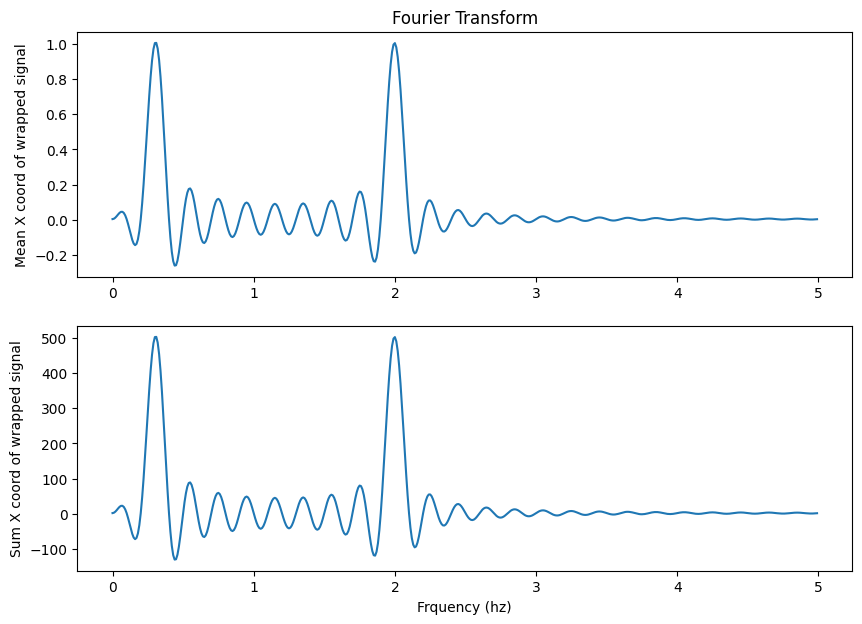

In [33]:
# the final fourier result is plotting the mean of the x coordinate on a continuous frequency variable
frequencies = np.arange(0, 5, step=0.01)
# initialize the resulting x coordinates of the center of gravity (mean of x)
x_means = []
# The actual value used in fourier transform is the sum of the x coordinates, not the mean
# should give the same signal, just scaled by the number of points
x_sums = []
# compute the wrapped signal at each frequency value
for freq in frequencies:
    wrapped_x, wrapped_i = get_wrapped_signal(t, y_3, freq)
    x_means.append(wrapped_x.mean())
    x_sums.append(wrapped_x.sum())

# plot the resulting fourier transform (values of x_means)
fig, axs = plt.subplots(2, 1, figsize=(10, 7))
axs[0].plot(t, x_means);
axs[1].plot(t, x_sums);
axs[0].set_title('Fourier Transform');
axs[1].set_xlabel("Frquency (hz)");
axs[1].set_ylabel("Sum X coord of wrapped signal");
axs[0].set_ylabel("Mean X coord of wrapped signal");


## Vectorize Fourier Function

We will turn the frequencies list into a vertical (N, 1) vector
so the resulting wrapped_x will be a (N, N) matrix. To multiply by the signal
and add the results at the same time, we will us the dot function of the matrix by the signal:
(N, N) dot (N) = (N)

In [34]:
def fourier_transform(t, signal, freqs):
    """
    Returns the resulting wrapped signal as the x and i values at the desired frequency
    """
    # get the euler angles at the given frequence
    euler_angles = -2 * np.pi * freqs * t
    # compute euler values
    euler_x, euler_i = compute_euler(euler_angles)
    # multiply by the signal to wrap it as a circle
    x_sums = np.dot(euler_x, signal)
    i_sums = np.dot(euler_i, signal)

    return x_sums, i_sums

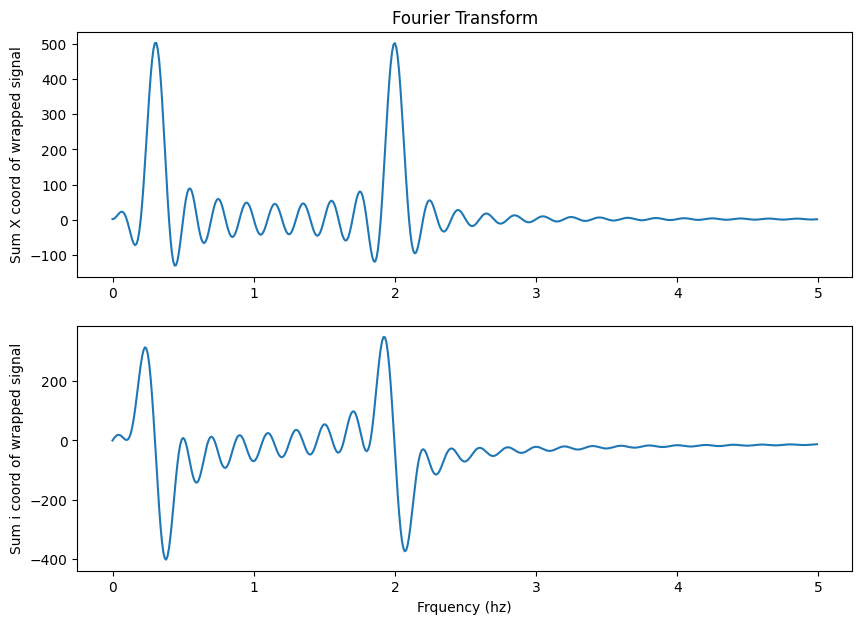

In [35]:
# the final fourier result is plotting the mean of the x coordinate on a continuous frequency variable
frequencies = t.reshape((len(t), 1))
# compute the fourier transform
x_sums, i_sums = fourier_transform(t, y_3, frequencies)

# plot the resulting fourier transform (values of x_means)
fig, axs = plt.subplots(2, 1, figsize=(10, 7))
axs[0].plot(t, x_sums);
axs[1].plot(t, i_sums);
axs[0].set_title('Fourier Transform');
axs[1].set_xlabel("Frquency (hz)");
axs[1].set_ylabel("Sum i coord of wrapped signal");
axs[0].set_ylabel("Sum X coord of wrapped signal");


We can see that the function has peaks at Frequency = 0.3 and 2, which are the frequencies of the two original signals that formed the combined y_3 signal.

If the original functions were using sin instead of cos, the peaks would be in the i coordinate of the euler results, not the x

In [36]:
def plot_fourier(freq=1):
    wrapped_x, wrapped_i = get_wrapped_signal(t, y_3, freq)
    # compute the center of gravity of the resulting funtion
    center_grav = (wrapped_x.mean(), wrapped_i.mean())
    
    plot_imaginary_plane(wrapped_x, wrapped_i)
    # plot the center of gravity onto the imaginary plane
    plt.plot(*center_grav, 'rp', markersize=8);
    # set the x and y ticks so the ratio of the plot is correctly squared
    ticks = np.arange(-5, 6, step = 1)
    plt.xticks(ticks);
    plt.yticks(ticks);

In [37]:
ipywidgets.interact(plot_fourier, freq=(0, 5, 0.01));

interactive(children=(FloatSlider(value=1.0, description='freq', max=5.0, step=0.01), Output()), _dom_classes=…

#### Proper Discrete Fourier Transform (DFT)

Actual discrete fourier multiplying by n and not t
thus resulting in euler((1/N)*2*pi*n_cicles*n) which is the formula of the discrete fourier transform.

So, instead of using a list of frequencies for the formula, we will pass only a set of points, and the frequency will be computed 
in relation to the sampling rate (number of samples) and the sampling interval (the time step at wich we collect each sample, in this case 0.01)

Based on: https://pythonnumericalmethods.berkeley.edu/notebooks/chapter24.02-Discrete-Fourier-Transform.html

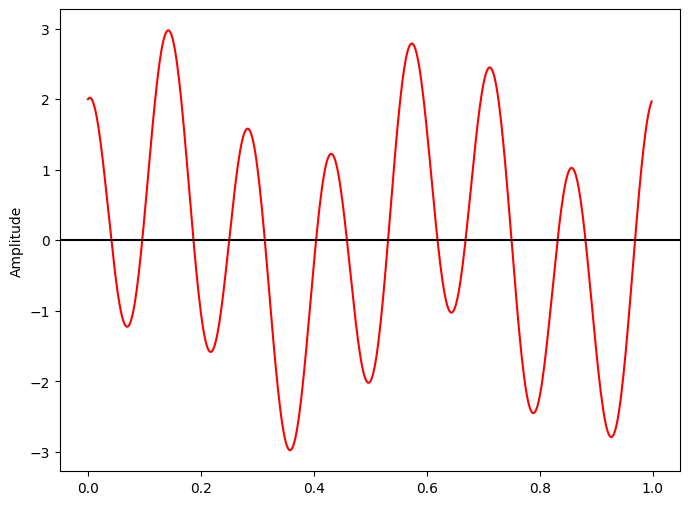

In [17]:
# sampling rate
sampling_rate = 500
# sampling interval
sampling_interval = 1.0 / sampling_rate
# create the t values from 0 to 1
t = np.arange(0, 1, sampling_interval)
ampl = 2

freq = 7 # use 7 freq thistime for easier visualization
x = ampl*np.cos(2*np.pi*freq*t)

freq = 2
x += np.sin(2*np.pi*freq*t)

plt.figure(figsize = (8, 6))
plt.plot(t, x, 'r')
plt.ylabel('Amplitude')
plt.axhline(y=0, color='k');

In [18]:
def get_wrapped_signal_dft(t, signal, k):
    """
    Returns the resulting wrapped signal as the x and i values at the desired k = cycles of all points
    """
    # actual discrete fourier multiplying by n and not t
    # thus resulting in euler((1/N)*2*pi*n_cicles*n) which is the formula of the discrete fourier transform
    # get the number of points
    N = len(t)
    # create a list from 0 to N-1
    n = np.arange(N)
    # get the euler angles at the given frequence
    euler_angles = -(1/N) * 2 * np.pi * k * n
    # compute euler values
    euler_x, euler_i = compute_euler(euler_angles)
    # multiply by the signal to wrap it as a circle
    wrapped_x, wrapped_i = signal*euler_x, signal*euler_i

    return wrapped_x, wrapped_i

In [19]:
def discrete_fourier_transform(x):
    """
    Function to calculate the 
    discrete Fourier Transform 
    of a 1D real-valued signal x
    """
    # get the number of points
    N = len(x)
    # create a list from 0 to N-1
    n = np.arange(N)
    # get the vertical vector K by reshaping n
    k = n.reshape((N, 1))
    # compute the euler value directly with the imaginary number j
    # it will return the expression (x + i)
    e = np.exp(-2j * np.pi * k * n / N)
    # dot product with the signal values to wrap the function
    dft_values = np.dot(e, x)
    
    return dft_values

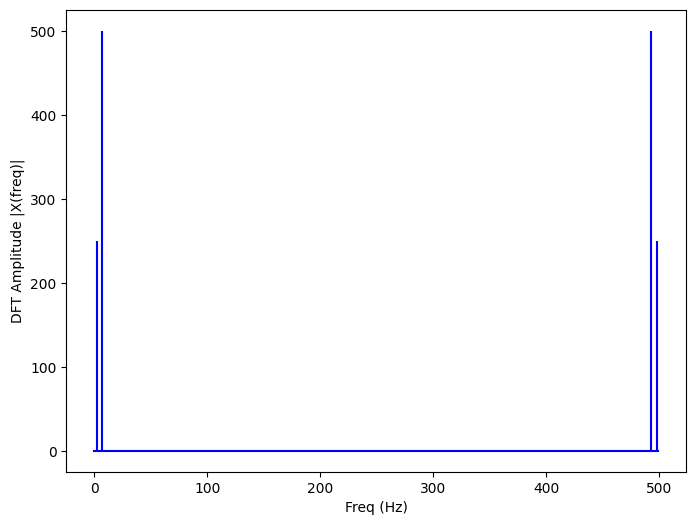

In [20]:
# get the dft values (real + imaginary)
dft_values = discrete_fourier_transform(x)

# calculate the frequency using the sampling rate
N = len(dft_values)
n = np.arange(N)
T = N/sampling_rate
freq = n/T # (0 to 500)

plt.figure(figsize = (8, 6))
plt.stem(freq, abs(dft_values), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('DFT Amplitude |X(freq)|')
plt.show()

We can see from here that the output of the DFT is symmetric at half of the sampling rate (you can try different sampling rate to test). This half of the sampling rate is called Nyquist frequency or the folding frequency, it is named after the electronic engineer Harry Nyquist. He and Claude Shannon have the Nyquist-Shannon sampling theorem, which states that a signal sampled at a rate can be fully reconstructed if it contains only frequency components below half that sampling frequency, thus the highest frequency output from the DFT is half the sampling rate.

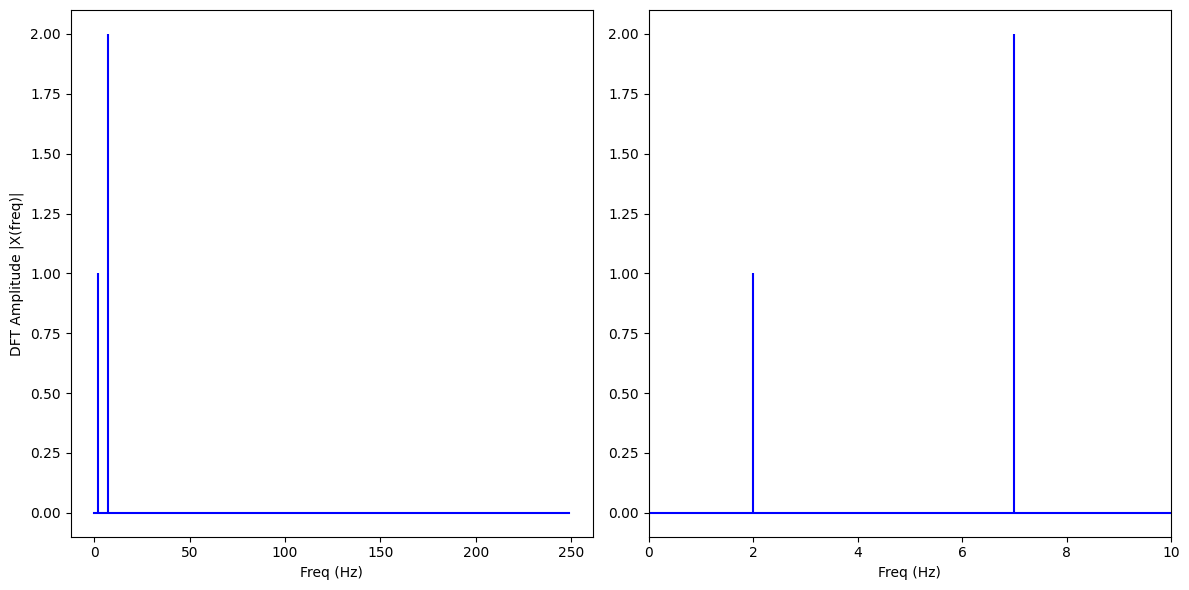

In [21]:
n_oneside = N//2
# get the one side frequency
f_oneside = freq[:n_oneside]

# normalize the amplitude
X_oneside =dft_values[:n_oneside]/n_oneside

plt.figure(figsize = (12, 6))
plt.subplot(121)
plt.stem(f_oneside, abs(X_oneside), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('DFT Amplitude |X(freq)|')

plt.subplot(122)
plt.stem(f_oneside, abs(X_oneside), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.xlim(0, 10)
plt.tight_layout()
plt.show()